# Semestrální projekt - Počítačový návrh léčiv
## Jaroslav Kurfurst

V tomto projektu jsem se pokusil natrénovat a otestovat model pro klasifikaci inhibitorů lidských proteas. Proteasy se řadí do hlavních rodin podle charakteru katalytického místa na Aspartátové, Cysteinové, Serinové, Threoninové a Metaloproteasy. Zde jsem na molekulových cílech z rodin Aspartátových a Cysteinových proteas a molekulách na nich aktivních natrénoval klasifikační model, který po natrénování tyto látky do těchto dvou kategorií klasifikoval s 99% přesností.

### Data:
Z databáze ChEmbl jsem stáhnul data o látkách podle následujícího schématu:

|  . | ASP | CYS |
| --- | --- | --- |
| molekulových cílů: | 10 | 39 |
| aktivních molekul: | 5887 | 3105 |

Jako "aktivní molekulu" jsem považoval molekuly s IC50 < 10 uM. A molekulové cíle jsem bral pouze pocházející z "Homo Sapiens".


In [1]:
import pandas as pd
import numpy as np

# Předzpracování dat

In [2]:
# načtení .csv souboru
df = pd.read_csv("aspVScys.csv", encoding='UTF-8')

In [3]:
# přejmenování názvů sloupců na názvy neobsahující mezery
df.rename(lambda x:x.replace(' ','_'),axis='columns', inplace=True)

In [4]:
# vyčištění data.frame od záznamů bez informace o "Canonical_Smiles"
df_clean = df.query('Canonical_Smiles.notnull()')

In [5]:
df_clean

,Molecule,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Comment,Compound_Key,Assay,Assay_Description,...,Published_Relation,Published_Value,Published_Units,Canonical_Smiles,Data_Validity_Comment,Document_Journal,Document_Year,SRC_ID,UO_Units,Potential_Duplicate
0,CHEMBL1270934,IC50,=,22.00,nM,7.66,NaN,58,CHEMBL1273970,Inhibition of human BACE1 by FRET assay,...,NaN,NaN,NaN,CC#Cc1cccc(c1)[C@]2(N=C(N)N(C)C2=O)c3ccc(OC(F)...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
1,CHEMBL1271246,IC50,=,20.00,nM,7.70,NaN,65,CHEMBL1273970,Inhibition of human BACE1 by FRET assay,...,NaN,NaN,NaN,CN1C(=N[C@](C1=O)(c2ccc(OC(F)F)cc2)c3cccc(c3)C...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
2,CHEMBL1221688,IC50,=,14.50,nM,7.84,NaN,9r,CHEMBL1227797,Inhibition of human ICE,...,NaN,NaN,NaN,CC(C)[C@H](CC(=O)NCCn1cnc2cc(C)c(C)cc12)C(=O)N...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
3,CHEMBL1221689,IC50,=,23.80,nM,7.62,NaN,9s,CHEMBL1227797,Inhibition of human ICE,...,NaN,NaN,NaN,CC(C)[C@H](CC(=O)NCCn1c(C)nc2ccccc12)C(=O)N[C@...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
4,CHEMBL1221691,IC50,=,9.18,nM,8.04,NaN,9u,CHEMBL1227797,Inhibition of human ICE,...,NaN,NaN,NaN,CC(C)[C@H](CC(=O)NCCn1c(C)nc2cc(C)c(C)cc12)C(=...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
5,CHEMBL1269691,IC50,=,2.80,nM,8.55,NaN,29,CHEMBL1275122,Inhibition of renin in plasma,...,NaN,NaN,NaN,Cc1cc(Cl)c(OCCOc2ccc(cc2)[C@H]3CCNC[C@@H]3C(=O...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
6,CHEMBL1269688,IC50,=,3.40,nM,8.47,NaN,26,CHEMBL1275122,Inhibition of renin in plasma,...,NaN,NaN,NaN,CNC(=O)Cc1ccc(Cl)c(CN(C2CC2)C(=O)[C@H]3CNCC[C@...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
7,CHEMBL1269759,IC50,=,0.21,nM,9.68,NaN,46,CHEMBL1275165,Inhibition of renin in buffer,...,NaN,NaN,NaN,COCCCc1cc(CN(C2CC2)C(=O)[C@H]3CNCC[C@@H]3c4ccc...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False
8,CHEMBL1269696,IC50,=,2.00,nM,8.70,NaN,17,CHEMBL1275166,Inhibition of renin in plasma,...,NaN,NaN,NaN,COC(=O)NCc1ccc(Cl)c(CN(C2CC2)C(=O)[C@H]3CNCC[C...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,True
9,CHEMBL1269749,IC50,=,0.50,nM,9.30,NaN,27,CHEMBL1275166,Inhibition of renin in plasma,...,NaN,NaN,NaN,CC(=O)NCCc1ccc(Cl)c(CN(C2CC2)C(=O)[C@H]3CNCC[C...,NaN,Bioorg. Med. Chem. Lett.,2010,1,UO_0000065,False


In [6]:
# pro roztřídění záznamů do kategorií 'asp' a 'cys', podle toho, o jakou proteasu se jedná
asp_ids = 'CHEMBL2525 CHEMBL2111390 CHEMBL4822 CHEMBL2136 CHEMBL2581 CHEMBL286 CHEMBL3092 CHEMBL3295 CHEMBL3418 CHEMBL2094135'.split(' ')
cys_ids = 'CHEMBL1741221 CHEMBL4244 CHEMBL3776 CHEMBL1741207 CHEMBL2334 CHEMBL3885517 CHEMBL3430905 CHEMBL3831289 CHEMBL2111357 CHEMBL2954 CHEMBL2226 CHEMBL3468 CHEMBL2111361 CHEMBL3407316 CHEMBL4072 CHEMBL4801 CHEMBL3891 CHEMBL3308 CHEMBL4160 CHEMBL3131 CHEMBL2223 CHEMBL2111368 CHEMBL2111441 CHEMBL6195 CHEMBL3272 CHEMBL2517 CHEMBL6158 CHEMBL2225 CHEMBL2382 CHEMBL4884 CHEMBL2273 CHEMBL2111396 CHEMBL3038466 CHEMBL2111380 CHEMBL5037 CHEMBL5991 CHEMBL2252 CHEMBL3837 CHEMBL268'.split(' ')

In [7]:
# vytvoření nového sloupce 'category', jehož hodnoty vypovídají o rodině dané proteasy.
df_clean['category'] = df_clean.Target.apply(lambda x:'Asp' if x in asp_ids else 'Cys')

/root/miniconda3/envs/pnl/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# pro další práci budu potřebovat pouze sloupce 'Molecule', 'Canonical_Smilse', 'category', ostatní zahodím.
# Dále odstraním duplikované záznamy molekul, protože například aktivita byla pro některé cíle naměřena vícekrát
# nebo byla naměřena aktivita jedné látky pro více cílů z jedné kategorie. 

df_reduced = df_clean[['Molecule', 'Canonical_Smiles','category']].drop_duplicates()

In [9]:
df_reduced.to_csv('df_reduced.csv', index=False)

In [10]:
# po vyčištění a deduplikaci zůstane látek pro každou kategorii:
np.sum(df_reduced.category == 'Asp'), np.sum(df_reduced.category == 'Cys') # trochu nevyvazene kategorie

(5887, 3105)

# Generování Morganových fingerprintů

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools

In [12]:
# generování RDkit mol objektů ze Smiles a jejich uchování v pandas data.frame.
PandasTools.AddMoleculeColumnToFrame(df_reduced, smilesCol='Canonical_Smiles', molCol='mol')

,Molecule,Canonical_Smiles,category,mol
0,CHEMBL1270934,CC#Cc1cccc(c1)[C@]2(N=C(N)N(C)C2=O)c3ccc(OC(F)F)cc3,Asp,
1,CHEMBL1271246,CN1C(=N[C@](C1=O)(c2ccc(OC(F)F)cc2)c3cccc(c3)C#CC4CC4)N,Asp,
2,CHEMBL1221688,CC(C)[C@H](CC(=O)NCCn1cnc2cc(C)c(C)cc12)C(=O)N[C@@H](CC(=O)O)C=O,Cys,
3,CHEMBL1221689,CC(C)[C@H](CC(=O)NCCn1c(C)nc2ccccc12)C(=O)N[C@@H](CC(=O)O)C=O,Cys,
4,CHEMBL1221691,CC(C)[C@H](CC(=O)NCCn1c(C)nc2cc(C)c(C)cc12)C(=O)N[C@@H](CC(=O)O)C=O,Cys,

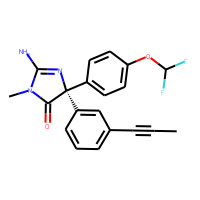
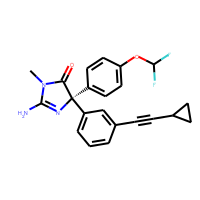
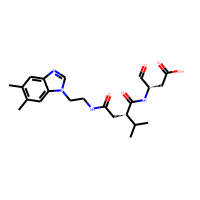
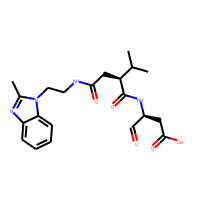
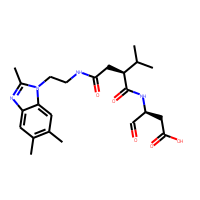

In [13]:
df_reduced.head()

In [14]:
# vygenerování Morganových fingerprintů v podobě BitStringu. 
df_reduced['fingerprint'] = df_reduced.mol.apply(lambda m:AllChem.GetMorganFingerprintAsBitVect(m,3).ToBitString())


# Vizualizace chemického prostoru pomocí PCA

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from sklearn.decomposition import PCA

In [17]:
# přetransformování Morganova fingerpringu do pole, místo bitStringu, ve kterém byly uchovány teď
fps = [np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_reduced.fingerprint]

,Molecule,Canonical_Smiles,category,mol,fingerprint
0,CHEMBL1270934,CC#Cc1cccc(c1)[C@]2(N=C(N)N(C)C2=O)c3ccc(OC(F)F)cc3,Asp,,01000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000100000000000010100010000000000000000000010000000000000000000000000000000000000100000001000000000000000000000000000011000000000000000000000000010000000000000000000000000010000000000000000000000001000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000100000000000000000000000000000000000000000000000001000000000000000000000000100000000000001000000000100000000000000000000100000000000000100000001000110000000000000000000000000000000000000000000000001000000000000000000000000000000000001000000000000000001000000010000000000000000000000000000000000000000100001000000010000000000100000000000000000000000000000000100100100000000000000000000000000000100000000000000000010000000000000000000000000000000000000000000000000001000000000010000001001000000000000000000000000000100000000000000000000000000000000000000000000000000000000100000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000010000000000000000000000000000000100000000100000000000000000000000000000000001100000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000010000000100000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101001000000000000000000000000010000000000000000000000000100000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000
1,CHEMBL1271246,CN1C(=N[C@](C1=O)(c2ccc(OC(F)F)cc2)c3cccc(c3)C#CC4CC4)N,Asp,,010000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000101000100000000000000000000100000000000000000000000000000000000001000000010000000000000000000000000000010000000000000000001000000100000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000010000000000000000001000000000000000000000000000000000000000000000000010000000000000000000000001100000000000010000000001000000000000000000011000000000000001000000010001100000000000000000000000000000000000000000000000010100000000000000000000000000000000010000000000000000010000000100000000000000000000000000000000000000001000010000000000000000000100000000000000000000000001000001001001000000000000000000000000000001000000000000000000100000000000000000000000000000001000000000000000000010000000000100000010010000000000000000000000000001000000000000000000000000000000000000000000000000000000001000000000000000000000000110010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000001000000000000000000000100000000000000000000000000000001000000001000000000000000000000000000000000011000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000100000001000000
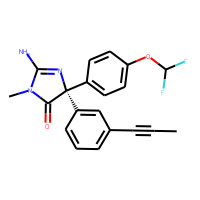
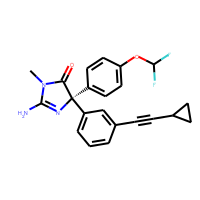
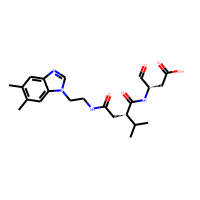
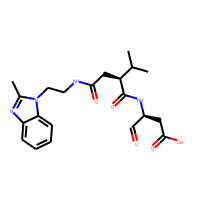
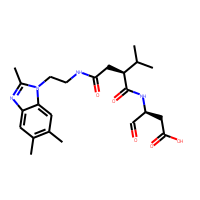

In [18]:
df_reduced.head()

In [19]:
# spočítání PCA
pca = PCA()
components = pca.fit_transform(fps)

In [20]:
components

array([[-1.41935526, -1.0528367 , -1.12092355, ..., -0.03353151,
         0.02746665, -0.018523  ],
       [-1.5881726 , -0.8631751 , -1.32779175, ...,  0.01083442,
        -0.01029807,  0.00906262],
       [ 0.45019616,  0.05369843,  0.19610054, ...,  0.05569944,
        -0.02516751,  0.01159706],
       ...,
       [ 3.61394304, -0.57457231,  0.71424749, ..., -0.01124666,
        -0.00978598,  0.02577458],
       [-1.05797284,  0.93928773, -0.10778199, ...,  0.04662302,
        -0.03739256,  0.04502651],
       [-1.68399907,  0.03628386, -0.91760234, ...,  0.06233752,
         0.01013902, -0.02216159]])

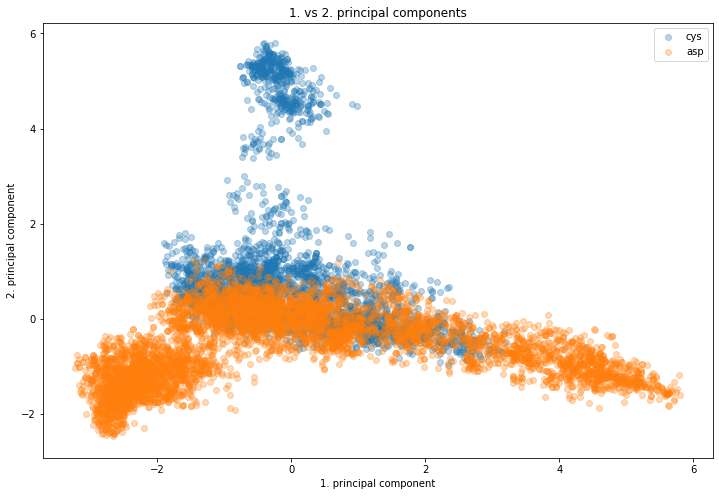

In [21]:
# vizualizace PCA pomocí matplotlib
plt.figure(figsize=(12,8))
mask_cys = df_reduced.category == 'Cys'
mask_asp = df_reduced.category == 'Asp'
plt.scatter(components[mask_cys,0], components[mask_cys,1], label='cys', alpha=0.3)
plt.scatter(components[mask_asp,0], components[mask_asp,1], label='asp', alpha=0.3)
plt.xlabel("1. principal component")
plt.ylabel("2. principal component")
plt.title("1. vs 2. principal components")
plt.legend()

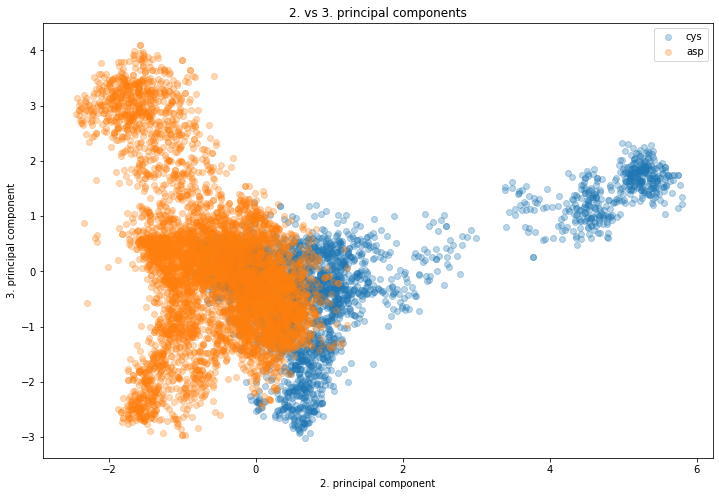

In [22]:
# vizualizace PCA pomocí matplotlib
plt.figure(figsize=(12,8))
mask_cys = df_reduced.category == 'Cys'
mask_asp = df_reduced.category == 'Asp'
plt.scatter(components[mask_cys,1], components[mask_cys,2], label='cys', alpha=0.3)
plt.scatter(components[mask_asp,1], components[mask_asp,2], label='asp', alpha=0.3)
plt.xlabel("2. principal component")
plt.ylabel("3. principal component")
plt.title("2. vs 3. principal components")
plt.legend()

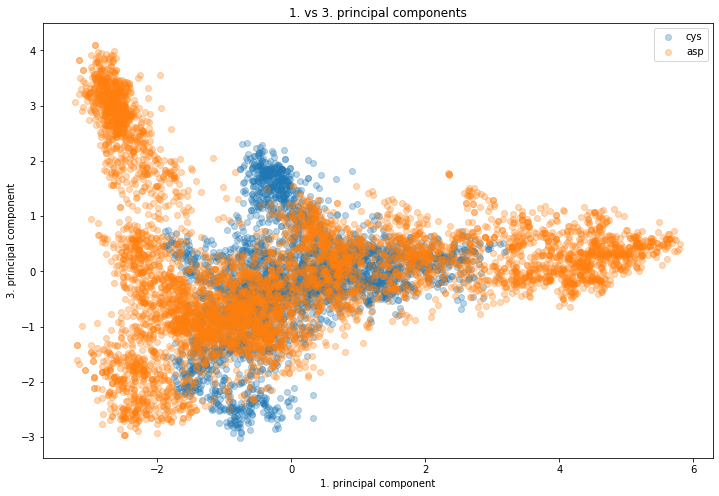

In [23]:
# vizualizace PCA pomocí matplotlib
plt.figure(figsize=(12,8))
mask_cys = df_reduced.category == 'Cys'
mask_asp = df_reduced.category == 'Asp'
plt.scatter(components[mask_cys,0], components[mask_cys,2], label='cys', alpha=0.3)
plt.scatter(components[mask_asp,0], components[mask_asp,2], label='asp', alpha=0.3)
plt.xlabel("1. principal component")
plt.ylabel("3. principal component")
plt.title("1. vs 3. principal components")
plt.legend()

# Vizualizace chemického prostoru redukcí dimenzionality: MDS

Další ze způsobů, jak vizualizovat mnohodimenzionální protstor je pomocí MDS - Multidimensional scaling. Zde se jednotlivé záznamy převedou z n-dimenzí do například dvou, za zachování vzálenosti mezi nimi

In [34]:
from sklearn.manifold import MDS

In [37]:
df_reduced_MDS = df_reduced[1:2000]
fps = [np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_reduced_MDS.fingerprint]

mds = MDS(n_components=2,)
fps_transfo = mds.fit_transform(fps)

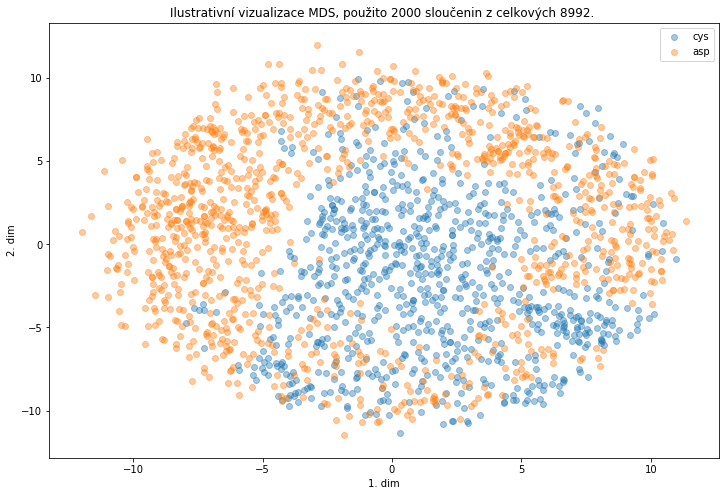

In [43]:
#vizualizace MDS pomocí matplotlib
plt.figure(figsize=(12,8))
mask_cys = df_reduced_MDS.category == 'Cys'
mask_asp = df_reduced_MDS.category == 'Asp'
plt.scatter(fps_transfo[mask_cys,0], fps_transfo[mask_cys,1], label='cys', alpha=0.4)
plt.scatter(fps_transfo[mask_asp,0], fps_transfo[mask_asp,1], label='asp', alpha=0.4)
plt.xlabel("1. dim")
plt.ylabel("2. dim")
plt.title("Ilustrativní vizualizace MDS, použito 2000 sloučenin z celkových 8992. ")
plt.legend()

# Classification

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [28]:
# rozdělení dat na trénovací a testovací v poměru 0.7 : 0.3
fps_train, fps_test, cat_train, cat_test = train_test_split(fps, df_reduced.category, train_size=0.7)

In [29]:
# random forest jako klasifikační model
rf = RandomForestClassifier()

In [30]:
# natrénování modelu na trénovacích datech
rf.fit(fps_train, cat_train)

/root/miniconda3/envs/pnl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
# aplikace modelu na testovací data
cat_pred = rf.predict(fps_test)

In [32]:
# zvolená metrika na ohodnocení modelu: accuracy
accuracy_score(cat_pred, cat_test)

0.9955522609340252

In [33]:
# další způsob, jak vyhodnotit úspěšnost modelu: confusion matrix
confusion_matrix(cat_pred, cat_test)

array([[1768,   11],
       [   1,  918]])

__Správně klasifikovaných Asp proteas:__ 1775  
__Správně klasifikovaných Cys proteas:__ 907  
__Špatně klasifikovaných Asp proteas jako Cys proteasy__: 2  
__Špatně klasifikovaných Cys proteas jako Asp proteasy:__ 14  